In [9]:
import numpy as np

import keras
import keras.backend as K
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.fugure_format = 'retina'

In [10]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
print(K.image_data_format())

channels_last


In [12]:
IMAGE_PATCH_SHAPE = (64, 64, 1)

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Lambda, Flatten, BatchNormalization, Activation
from keras.regularizers import l2
    
WEIGHT_DECAY = 5e-4 / 2
    
# siam-l2 from "Learning to Compare Image Patches via Convolutional Neural Networks"
descriptor = Sequential()

descriptor.add(Lambda(lambda x : (K.cast(x, 'int16') - 128) / 128, input_shape=IMAGE_PATCH_SHAPE))

descriptor.add(Conv2D(96, kernel_size=7, strides=3, kernel_regularizer=l2(WEIGHT_DECAY)))
descriptor.add(BatchNormalization())
descriptor.add(Activation('relu'))
descriptor.add(MaxPooling2D(pool_size=2, strides=2))
descriptor.add(Dropout(0.2))

descriptor.add(Conv2D(192, kernel_size=5, strides=1, kernel_regularizer=l2(WEIGHT_DECAY)))
descriptor.add(BatchNormalization())
descriptor.add(Activation('relu'))
descriptor.add(MaxPooling2D(pool_size=2, strides=2))
descriptor.add(Dropout(0.2))

descriptor.add(Conv2D(256, kernel_size=3, strides=1, kernel_regularizer=l2(WEIGHT_DECAY)))
descriptor.add(BatchNormalization())
descriptor.add(Activation('relu'))
descriptor.add(Flatten())
descriptor.add(Lambda(lambda x : tf.nn.l2_normalize(x, axis=1, epsilon=1e-10))) # TODO check normalization

print(descriptor.input_shape, descriptor.output_shape)

(None, 64, 64, 1) (None, 256)


In [14]:
from keras.models import Model
from keras.layers import Input

input_a = Input(shape=IMAGE_PATCH_SHAPE)
input_b = Input(shape=IMAGE_PATCH_SHAPE)

descriptor_a = descriptor(input_a)
descriptor_b = descriptor(input_b)

def euclidean_distance(vects):
    assert len(vects) == 2
    x, y = vects
    return -(K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True)) - 1)

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([descriptor_a, descriptor_b])
model = Model(inputs=[input_a, input_b], outputs=distance)

print(model.input_shape, model.output_shape)

[(None, 64, 64, 1), (None, 64, 64, 1)] (None, 1)


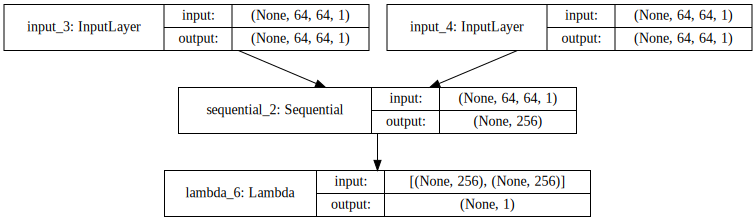

In [19]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [20]:
DATA_ROOT = '../data'
NOTREDAME = f'{DATA_ROOT}/notredame'
LIBERTY = f'{DATA_ROOT}/liberty'

!ls {NOTREDAME}/m50_*.txt

../data/notredame/m50_100000_100000_0.txt
../data/notredame/m50_10000_10000_0.txt
../data/notredame/m50_1000_1000_0.txt
../data/notredame/m50_200000_200000_0.txt
../data/notredame/m50_20000_20000_0.txt
../data/notredame/m50_2000_2000_0.txt
../data/notredame/m50_500000_500000_0.txt
../data/notredame/m50_50000_50000_0.txt
../data/notredame/m50_5000_5000_0.txt


In [21]:
from keras.optimizers import SGD, Adam
from keras.losses import hinge

model.compile(loss=hinge, optimizer=Adam())

In [25]:
!rm -r logs/

In [23]:
%autoreload
from utils import create_generator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from batchtensorboard import BatchTensorBoard

NUM_TRAIN_PAIRS = 5000
NUM_VAL_PAIRS = 1000
BATCH_SIZE = 128
NUM_TRAIN_STEPS = NUM_TRAIN_PAIRS // BATCH_SIZE
NUM_VAL_STEPS = NUM_VAL_PAIRS // BATCH_SIZE

train_generator = create_generator(NOTREDAME, NUM_TRAIN_PAIRS, BATCH_SIZE)
validation_generator = create_generator(LIBERTY, NUM_VAL_PAIRS, BATCH_SIZE)

tensorboard = BatchTensorBoard()
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=0.000001)
checkpointer = ModelCheckpoint('siam-l2-weights.hdf5')

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=NUM_TRAIN_STEPS, epochs=100, 
    validation_data=validation_generator, validation_steps=NUM_VAL_STEPS, 
    callbacks=[tensorboard, checkpointer])

Epoch 1/100
39/39 [==============================] - 1s 37ms/step - loss: 0.5398 - val_loss: 0.8082
Epoch 2/100
39/39 [==============================] - 2s 39ms/step - loss: 0.5420 - val_loss: 0.8242
Epoch 3/100
39/39 [==============================] - 2s 40ms/step - loss: 0.5313 - val_loss: 0.8115
Epoch 4/100
39/39 [==============================] - 2s 40ms/step - loss: nan - val_loss: nan
Epoch 5/100
39/39 [==============================] - 2s 40ms/step - loss: nan - val_loss: nan
Epoch 6/100
39/39 [==============================] - 2s 40ms/step - loss: nan - val_loss: nan
Epoch 7/100
39/39 [==============================] - 2s 40ms/step - loss: nan - val_loss: nan
Epoch 8/100
39/39 [==============================] - 2s 40ms/step - loss: nan - val_loss: nan
Epoch 9/100
39/39 [==============================] - 2s 40ms/step - loss: nan - val_loss: nan
Epoch 10/100
39/39 [==============================] - 2s 40ms/step - loss: nan - val_loss: nan
Epoch 11/100
39/39 [=====================

In [ ]:
inputs, true = next(create_generator(LIBERTY, num_pairs=1000, batch_size=1000))
pred = model.predict(inputs)

In [ ]:
print(pred.reshape(-1)[:30])

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(true, pred)
roc_auc = auc(fpr, tpr)
plt.grid()
plt.plot(fpr, tpr, label=f'AUC={roc_auc:0.2f}')
plt.legend()
plt.show()

In [ ]:
model.layers

In [ ]:
descr = model.layers[2]
embeddings = descr.predict(inputs[0])

In [ ]:
from numpy.linalg import norm

sum(norm(e) for e in embeddings)